# 1. APP Loading

## 1.0. Open Database

In [1]:
import requests
import pandas as pd
import sqlite3
import tqdm
import requests as rq
from bs4 import BeautifulSoup
from io import BytesIO
import re
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"
import myAPI_keys as Key
import db.init_db as init_db



init_db.init_entire_database()
print("Database initilized! load data from API and insert into database...")


conn = sqlite3.connect("db/StockManageAPP.sqlite")

cur = conn.cursor()

Database initilized! load data from API and insert into database...


/Users/jiho/Desktop/DB_API_assignment/db/init_db.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[1] = str(row[1]).zfill(6)
/Users/jiho/Desktop/DB_API_assignment/db/init_db.py:55: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[1] = str(row[1]).zfill(6)


## 1.1. Update [StockInfo] Table

### 1.1.1. Defince Function : Get_Stock_Price 
- 한국증권거래소 API에 종목코드를 파라미터로 이용해, 종목명과 종가 가져옴.

In [2]:
def Get_Stock_Info():
    endpoint = "http://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo"
    url = f"{endpoint}?pageNo={1}&resultType=json&numOfRows={3000}&serviceKey={Key.STOCK_INFO_ENCODED_KEY}"
    response = requests.get(url).json().get("response").get("body").get("items")
    return response

### 1.1.2. [StockInfo Table(df)] 초기 형태 제작
- 금융결제원 API로 불러온 정보를 마지막 검색일자인 정보만 남김.
- 이후 StockInfo의 형태로 df를 제작

In [3]:
_ans = Get_Stock_Info()
df = pd.DataFrame(_ans.get("item"))[["srtnCd", "itmsNm", "mrktCtg", "clpr", "basDt"]]
last_date = df["basDt"].max()
df = df[df["basDt"] == last_date]
########################################################################
df = pd.DataFrame(df)[["srtnCd", "itmsNm", "mrktCtg", "clpr"]]
df = df.rename(
    columns={
        "srtnCd": "StockCode",
        "itmsNm": "StockName",
        "mrktCtg": "Category",
        "clpr": "Price",
    }
)
df = df.drop(df[df['Category'] == 'KONEX'].index)


In [4]:
df

,StockCode,StockName,Category,Price
0,900110,이스트아시아홀딩스,KOSDAQ,122
1,900270,헝셩그룹,KOSDAQ,221
2,900260,로스웰,KOSDAQ,740
3,900290,GRT,KOSDAQ,2745
4,900300,오가닉티코스메틱,KOSDAQ,136
...,...,...,...,...
2771,900120,씨케이에이치,KOSDAQ,113
2772,900250,크리스탈신소재,KOSDAQ,1712
2773,900070,글로벌에스엠,KOSDAQ,568
2774,900140,엘브이엠씨홀딩스,KOSPI,2440


### 1.1.2. load category table (in memory)
- http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020502
- KRX에서 업종정보 포함한 종합 정보 csv file 다운 후, 메모리에 불러옴
- 해당 사이트의 API를 이용하기 위해선, 사업자등록번호가 필요하기 때문에 불가피하게 csv file을 다운받아서 사용함.

In [5]:
# Load the two CSV files with 'euc-kr' encoding
df1 = pd.read_csv("db/doc/data_2239_20231121.csv", encoding="euc-kr")
df2 = pd.read_csv("db/doc/data_2303_20231121.csv", encoding="euc-kr")

# Concatenate the two DataFrames
df3 = pd.concat([df1, df2])

# If you want to reset the index
krx_sector = df3.reset_index(drop=True)

In [6]:
krx_sector

,종목코드,종목명,시장구분,업종명,종가,대비,등락률,시가총액
0,095570,AJ네트웍스,KOSPI,서비스업,4165,15,0.36,188477741235
1,006840,AK홀딩스,KOSPI,기타금융,17980,-20,-0.11,238191146780
2,027410,BGF,KOSPI,기타금융,3570,30,0.85,341708943870
3,282330,BGF리테일,KOSPI,유통업,135400,1900,1.42,2340240872400
4,138930,BNK금융지주,KOSPI,기타금융,7100,30,0.42,2286827909800
...,...,...,...,...,...,...,...,...
2642,024060,흥구석유,KOSDAQ,유통,8710,340,4.06,130650000000
2643,010240,흥국,KOSDAQ,기계·장비,5900,50,0.85,72703906400
2644,189980,흥국에프엔비,KOSDAQ,음식료·담배,2090,40,1.95,83888058430
2645,037440,희림,KOSDAQ,기타서비스,8280,220,2.73,115278093000


### 1.1.3. Add Stock{Name, Price} to [StockInfo(df)] by using API

In [7]:
for _StockCode in tqdm.tqdm(df["StockCode"].tolist()):
    # Find the matching row in krx_sector
    matching_sector = krx_sector[krx_sector["종목코드"] == _StockCode]["업종명"]
    if(len(matching_sector) == 0):
        continue
    df.loc[df["StockCode"] == _StockCode, "Category"] = matching_sector.values[0]

  0%|          | 0/2647 [00:00<?, ?it/s]

100%|██████████| 2647/2647 [00:00<00:00, 2966.04it/s]


In [8]:
# 2776개에 2647개의 업종명이 매칭되었는데, 나머지 129개는 시장명으로 되어있는 상태. 어떻게 해야할 지 모르겠음.
df

,StockCode,StockName,Category,Price
0,900110,이스트아시아홀딩스,금융,122
1,900270,헝셩그룹,금융,221
2,900260,로스웰,금융,740
3,900290,GRT,금융,2745
4,900300,오가닉티코스메틱,금융,136
...,...,...,...,...
2771,900120,씨케이에이치,금융,113
2772,900250,크리스탈신소재,금융,1712
2773,900070,글로벌에스엠,금융,568
2774,900140,엘브이엠씨홀딩스,유통업,2440


### 1.1.4. 만든 df Table을 [StockInfo table]에 대입

In [9]:
# Iterate over the rows of the DataFrame
for index, row in df.iterrows():
    # Create the INSERT statement
    sql = f"""
    INSERT INTO StockInfo (StockCode, StockName, Price, Category)
    VALUES ('{row['StockCode']}', '{row['StockName']}', {row['Price']}, '{row['Category']}')
    """

    # Execute the INSERT statement
    cur.execute(sql)

# Commit the changes and close the connection
conn.commit()

## 1.2. Update [UserInfo] Table 
- Update a [UserInfo].Blance
- Update a [UserInfo].FavoriteCategory

### 1.2.1 Update [UserInfo].Blance

In [10]:
sql = f"""
    SELECT ID, SUM(Count * Price) as TotalValue
    FROM (
        SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
        FROM IndividualStockAcount
        JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    )
    GROUP BY ID
    """

df = pd.read_sql_query(sql, conn)

In [11]:
df

,ID,TotalValue
0,hoho222,875100
1,hseop884,4167000
2,jiho264,657000
3,nick0422,810000
4,user270,406600


In [12]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the UserInfo table based on the temporary table
cur.execute(
    """
    UPDATE UserInfo
    SET Balance = (
        SELECT TotalValue
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = UserInfo.ID
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")  

conn.commit()

### 1.2.2. [IndividualStockAccount].TotalPrice

In [13]:
sql = f"""
    SELECT IndividualStockAcount.ID, IndividualStockAcount.StockCode, IndividualStockAcount.Count, StockInfo.Price
    FROM IndividualStockAcount
    JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
    """

df = pd.read_sql_query(sql, conn)

In [14]:
df

,ID,StockCode,Count,Price
0,hoho222,005930,3,72700
1,nick0422,035420,4,202500
2,jiho264,000660,5,131400
3,hoho222,000660,5,131400
4,user270,000660,1,131400
5,user270,005930,1,72700
6,user270,035420,1,202500
7,hseop884,086520,4,728000
8,hseop884,247540,5,251000


In [15]:
# Write the DataFrame to a temporary table in the SQLite database
df.to_sql("temp", conn, if_exists="replace", index=False)

# Update the individualstockaccount table based on the temporary table
cur.execute(
    """
    UPDATE IndividualStockAcount
    SET TotalPrice = (
        SELECT Count * Price
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
    WHERE EXISTS (
        SELECT 1
        FROM temp
        WHERE temp.ID = IndividualStockAcount.ID AND temp.StockCode = IndividualStockAcount.StockCode
    )
"""
)
cur.execute("DROP TABLE IF EXISTS temp")
conn.commit()

### 1.2.3. Update the [UserInfo].FavCategory column
- 각 Id마다의 Category별 TotalPrice합계를 구하고, 가장 큰 Category를 FavoriteCategory로 지정

In [16]:
# Get the category with the highest sum of TotalPrice for each ID
sql = """
SELECT IndividualStockAcount.ID, StockInfo.Category, SUM(IndividualStockAcount.TotalPrice) as Total
FROM UserInfo
LEFT JOIN IndividualStockAcount ON UserInfo.ID = IndividualStockAcount.ID
LEFT JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
GROUP BY IndividualStockAcount.ID, StockInfo.Category
"""

df = pd.read_sql_query(sql, conn)

# Find the category with the highest sum of TotalPrice for each ID
df = df.loc[df.groupby("ID")["Total"].idxmax()]

# Update the UserInfo table with the FavCategory
for index, row in df.iterrows():
    sql = f"""
    UPDATE UserInfo
    SET FavCategory = '{row['Category']}' 
    WHERE ID = '{row['ID']}'
    """
    cur.execute(sql)

conn.commit()

In [17]:
df

,ID,Category,Total
0,hoho222,전기전자,875100
1,hseop884,금융,2912000
3,jiho264,전기전자,657000
4,nick0422,서비스업,810000
6,user270,전기전자,204100


## 1.3. Update [IndividualStockAccount] Table

In [18]:
# Update the IndividualStockAcount table with the StockName based on the StockCode
cur.execute("""
UPDATE IndividualStockAcount
SET StockName = (
    SELECT StockName
    FROM StockInfo
    WHERE StockInfo.StockCode = IndividualStockAcount.StockCode
)
""")

# Commit the changes
conn.commit()


# 2. APP Running

## 2.1. Login

In [72]:
_user_ID = "user270"
_user_PW = "admin"

sql = f"""
SELECT *
FROM UserInfo
WHERE ID = '{_user_ID}' AND PW = '{_user_PW}'
"""

result = pd.read_sql_query(sql, conn)

if result.empty:
    print("ID or PW is wrong!")
else:
    print("Hello, " + _user_ID + "!")

Hello, user270!


## 2.2. Statistics of StockInfo about MyPage

In [85]:
def Circle_Plot(df, col, label, title):
    # Sum the data for the same category
    df_sum = df.groupby(label)[col].sum().reset_index()
    df_sum.sort_values(by=[col], ascending=False, inplace=True)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the circle plot
    wedges, texts, autotexts = ax.pie(
        df_sum[col], labels=df_sum[label], autopct="%1.1f%%"
    )

    # Add the TotalPrice near the label
    for i, text in enumerate(texts):
        text.set_text(f"{df_sum[label][i]}\n({df_sum[col][i]:,.0f} won)")

    # Set the aspect ratio to be equal so that the pie is drawn as a circle
    ax.set_aspect("equal")

    # Set the title of the plot
    ax.set_title(title)
    # Show the plot
    plt.show()

In [86]:
import pandas as pd

sql = f"""
SELECT *
FROM IndividualStockAcount
WHERE ID = '{_user_ID}'
"""

_my_stocks = pd.read_sql_query(sql, conn)
_my_stocks


,ID,StockCode,StockName,Count,TotalPrice
0,user270,000660,SK하이닉스,1,131400
1,user270,005930,삼성전자,1,72700
2,user270,035420,NAVER,1,202500


In [87]:
sql = f"""
SELECT Balance, Deposit
FROM UserInfo
WHERE ID = '{_user_ID}'
"""

_my_acount = pd.read_sql_query(sql, conn)
print("user all balance: " + str(sum(_my_acount.values[0])) + " won")
print("user balance: " + str(_my_acount.values[0][0]) + " won")
print("user deposit: " + str(_my_acount.values[0][1]) + " won")

user all balance: 522244 won
user balance: 406600 won
user deposit: 115644 won


In [88]:
if "000000" not in _my_stocks["StockCode"].values:
    new_row = {
        "ID": "user270",
        "StockCode": "000000",
        "StockName": "Deposit",
        "Count": 1,
        "TotalPrice": _my_acount.values[0][1],
    }
    _my_stocks = pd.concat([_my_stocks, pd.DataFrame([new_row])], ignore_index=True)


_my_stocks

,ID,StockCode,StockName,Count,TotalPrice
0,user270,000660,SK하이닉스,1,131400
1,user270,005930,삼성전자,1,72700
2,user270,035420,NAVER,1,202500
3,user270,000000,Deposit,1,115644


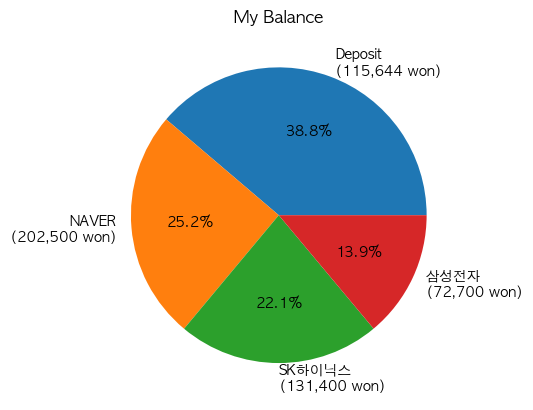

In [89]:
Circle_Plot(_my_stocks, "TotalPrice", "StockName", "My Balance")

## 2.3. Statistics of StockInfo about All Users
- 전체 증권사 회원들의 투자분표를 시각화해, 시장에 대한 개인의 대응을 보여줌

In [92]:
sql = """
SELECT StockInfo.Category, IndividualStockAcount.StockName, SUM(IndividualStockAcount.Count) as TotalCount, SUM(IndividualStockAcount.TotalPrice) as TotalPrice
FROM IndividualStockAcount
JOIN StockInfo ON IndividualStockAcount.StockCode = StockInfo.StockCode
GROUP BY StockInfo.Category, IndividualStockAcount.StockName
"""

result = pd.read_sql_query(sql, conn)
result

,Category,StockName,TotalCount,TotalPrice
0,금융,에코프로,4,2912000
1,서비스업,NAVER,5,1012500
2,일반전기전자,에코프로비엠,5,1255000
3,전기전자,SK하이닉스,11,1445400
4,전기전자,삼성전자,4,290800


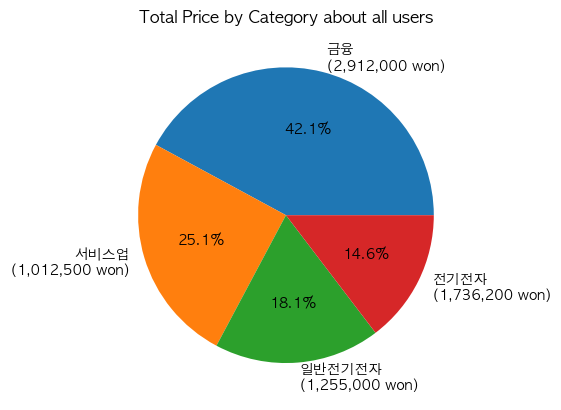

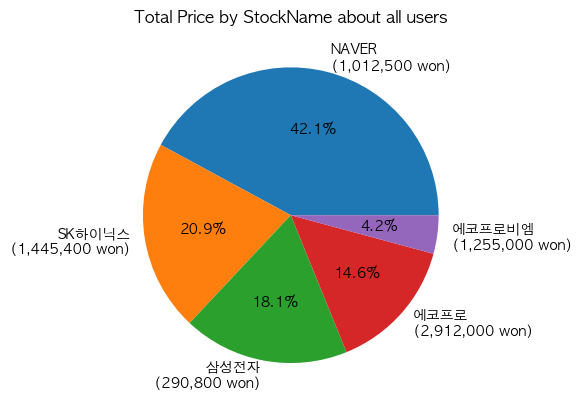

In [94]:
Circle_Plot(result, "TotalPrice", "Category", "Total Price by Category about all users")
Circle_Plot(result, "TotalPrice", "StockName", "Total Price by StockName about all users")

## 2.4. The stock which the USER do not bought in same category

In [98]:
sql = f"""
SELECT ID
FROM UserInfo
WHERE FavCategory = (
    SELECT FavCategory
    FROM UserInfo
    WHERE ID = '{_user_ID}'
)
AND ID != '{_user_ID}'
"""

print("me is : " + _user_ID)
other_users = pd.read_sql_query(sql, conn)
other_users


me is : user270


,ID
0,hoho222
1,jiho264


In [100]:
sql = f"""
SELECT StockInfo.StockName
FROM StockInfo
WHERE StockInfo.Category = (
    SELECT FavCategory
    FROM UserInfo
    WHERE ID = '{_user_ID}'
)
AND StockInfo.StockCode NOT IN (
    SELECT StockCode
    FROM IndividualStockAcount
    WHERE ID = '{_user_ID}'
)
AND StockInfo.StockCode IN (
    SELECT StockCode
    FROM IndividualStockAcount
    WHERE ID IN (
        SELECT ID
        FROM UserInfo
        WHERE FavCategory = (
            SELECT FavCategory
            FROM UserInfo
            WHERE ID = '{_user_ID}'
        )
        AND ID != '{_user_ID}'
    )
)
"""

result = pd.read_sql_query(sql, conn)
result


,StockName


# 999. Todo
- 동일 관심종목인 사람들과 비교해 본인이 구매하지 않은 종목은 무엇인지?

- 국민연금공단의 포트폴리오를 시각화하며, 본인과 얼마나 다른지 비교함

- 간략한 투자정보
-- 해외 뉴스, 환율 등 